# COVID-19 Mortality Rate Between Countries With Low and High Smoking Rate
By: _Ray Nguyen, Jeffrey Song, Asar Zuluev_


## Introduction
At the end of 2019, a viral disease which would be discovered to be caused by SARS-CoV-2 and later named COVID-19 first emerged in China. Then over the course of the next 12 months this novel disease would infect close to 100 million people and result in the deaths of 2 million people worldwide according to official figures (Carvalho et al., 2021). Symptoms of COVID-19 vary, but fever, cough, fatigue, shortness of breath are most common (Alimohamadi et al., 2020) however while “SARS-CoV-2 can have wide-ranging impacts throughout the body, COVID-19 remains predominantly a respiratory illness.”  (Desai et al., 2022). While smoking has been conclusively studied and attributed as a leading factor for death due to chronic respiratory diseases (Gan et al., 2022), there have been complications in research into the interactions of COVID-19 and smoking. As some studies have established a relationship between smoking and an increased risk for mortality in patients (Hou et al., 2021), others have found that current smokers and never smokers had few differences in death and ICU admission (Piasecki et al., 2022). Thus, an investigation into the relationship between countries’ smoking rates and COVID-19 death rates could be illuminating. We will investigate the average death rate as our location parameter and the standard deviation of the death rate as our scale parameter.

## Methods and Results

The dataset we used contains information about the COVID-19 pandemic that is updated daily by Our World in Data (Edouard et al. 2020). It can be found under [this URL](https://github.com/owid/covid-19-data/tree/master/public/data). The dataset includes data on confirmed cases, confirmed deaths, hospital & ICU, policy responses, vaccinations, etc. For this article, we only examined:





- location: Countries.
- male_smokers: proportion of male smokers, most recent year possible.
- female_smokers: proportion of female smokers, most recent year possible.
- new_deaths: new deaths attributed to COVID-19 (within 7 days).
- new_cases : new confirmed cases attributed of COVID-19 (within 7 days).


With this information, we transformed the data to fit our objective of analysing the mortality rate and smoking rate.

First, we installed libraries that are essential in implementing analysis and hypothesis testing.

In [2]:
library(tidyverse)
library(infer)
library(broom)
library(ggplot2)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




Next, we used read.csv() to read the dataset owid-covid-data, and used head() to visualize what it looked like. We recognized many observations in "new_deaths" and "new_cases" columns with NA values which we filtered out. Additionally, we filtered by Europe, America, and Oceania only as we found Asia had large discrepancies in their reporting of COVID-19 deaths, smoking proportion and COVID-19 cases. Next, we tidied the data by sorting out all the NA values in the "male_smokers" and "female_smokers" columns and grouped them by location. Since we were interested in the smoking rate of countries, we created a new column of total smokers by taking the average of male smoker and female smokers. Consequently, we summarized the dataset by adding the mean smokers and mortality rate columns.

In [3]:
data <- read.csv("https://raw.githubusercontent.com/RayNguyent/STAT-201-Project/main/data/owid-covid-data.csv")
data["new_cases"][is.na(data["new_cases"])] <- 0
data["new_deaths"][is.na(data["new_deaths"])] <- 0
data_cleaned <- data %>% filter(!is.na(male_smokers)) %>% filter(!is.na(female_smokers)) %>% filter(continent %in% c("Europe", "America","Africa","Oceania")) %>%
        group_by(location) %>% 
        mutate(smokers = (male_smokers + female_smokers)/2) %>% group_by(location) %>% 
        summarise(mean_smokers = mean(smokers), mortality_rate = sum(new_deaths)/sum(new_cases))
head(data_cleaned)


location,mean_smokers,mortality_rate
<chr>,<dbl>,<dbl>
Albania,29.15,0.010794177
Algeria,15.55,0.025411492
Andorra,33.40,0.003380051
Australia,14.75,0.001467342
Austria,29.65,0.003889079
Belarus,28.30,0.007160699


We plotted the distribution of mean smoking rate to determine the threshold to divide the countries into high and low smoking rate. As we observed from the graph that it is a little right-skewed, it is most reasonable to use the median as our cutoff. The median smoking rate is 23.3.

[1] 23.3

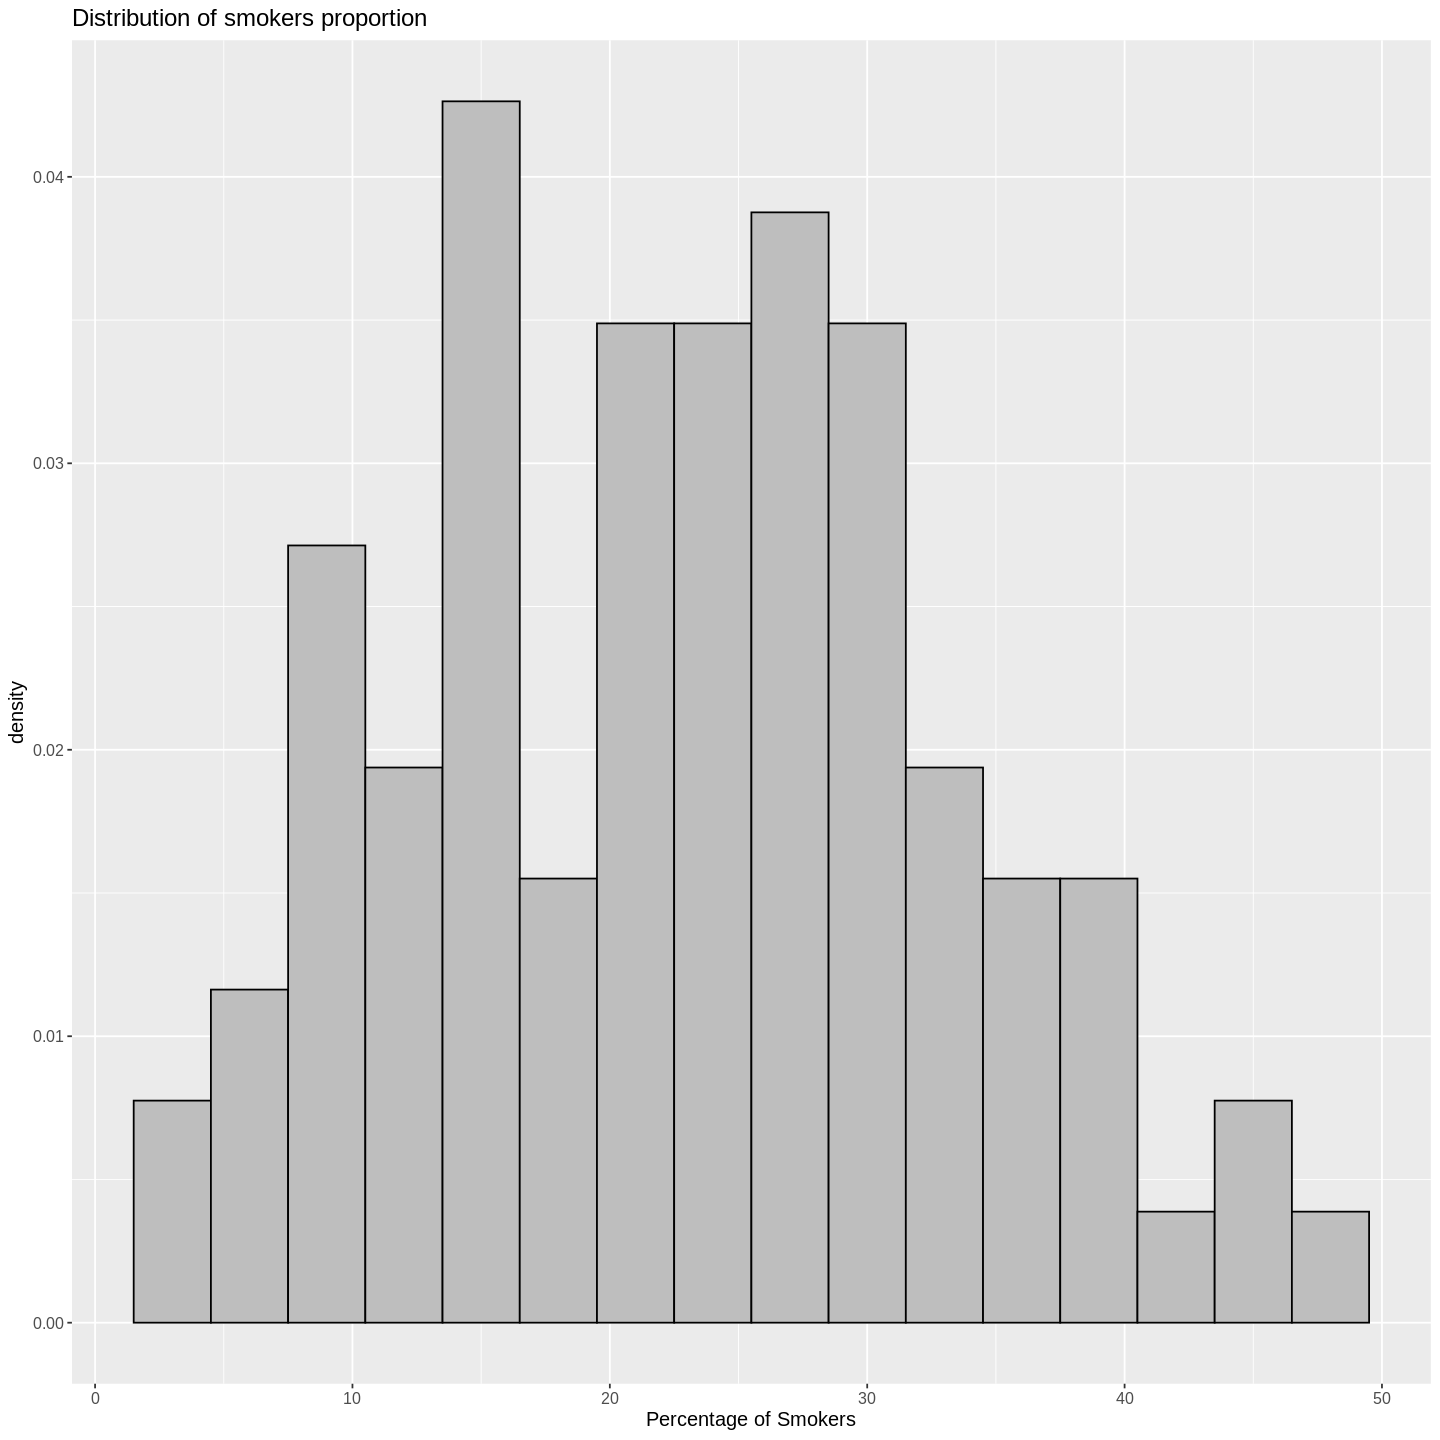

In [4]:
smokers_distri <- data_cleaned %>% ggplot(aes(x=mean_smokers, ..density..)) + geom_histogram(binwidth = 3, fill = "grey", color = "black") + labs(x = "Percentage of Smokers", title = "Distribution of smokers proportion") + 
        theme(text = element_text(size = 12))
smokers_distri
median(data_cleaned$mean_smokers)

To finalise our dataset, we created a new column indicates whether a country has high(> 23.3) or low smoking rate (<= 23.3). Only mortality rate and is_high_smoking_rate were kept in the final dataset.

In [5]:
data_final <- data_cleaned %>% mutate(is_high_smoking_rate = mean_smokers > 23.3) %>% select(-c(location, mean_smokers))
head(data_final)
    

mortality_rate,is_high_smoking_rate
<dbl>,<lgl>
0.010794177,TRUE
0.025411492,FALSE
0.003380051,TRUE
0.001467342,FALSE
0.003889079,TRUE
0.007160699,TRUE


The next step was to divide the dataset into two parts corresponding to high or low smoking rate in order to conduct a bootstrap distribution.

In [6]:
high_smoking_data <- data_final %>% filter(is_high_smoking_rate == "TRUE") %>% select(mortality_rate)
head(high_smoking_data)


low_smoking_data <- data_final %>% filter(is_high_smoking_rate == "FALSE") %>% select(mortality_rate)
head(low_smoking_data)

mortality_rate
<dbl>
0.010794177
0.003380051
0.003889079
0.007160699
0.007162074
0.040501623


mortality_rate
<dbl>
0.025411492
0.001467342
0.005823300
0.008549261
0.017890990
0.006586855


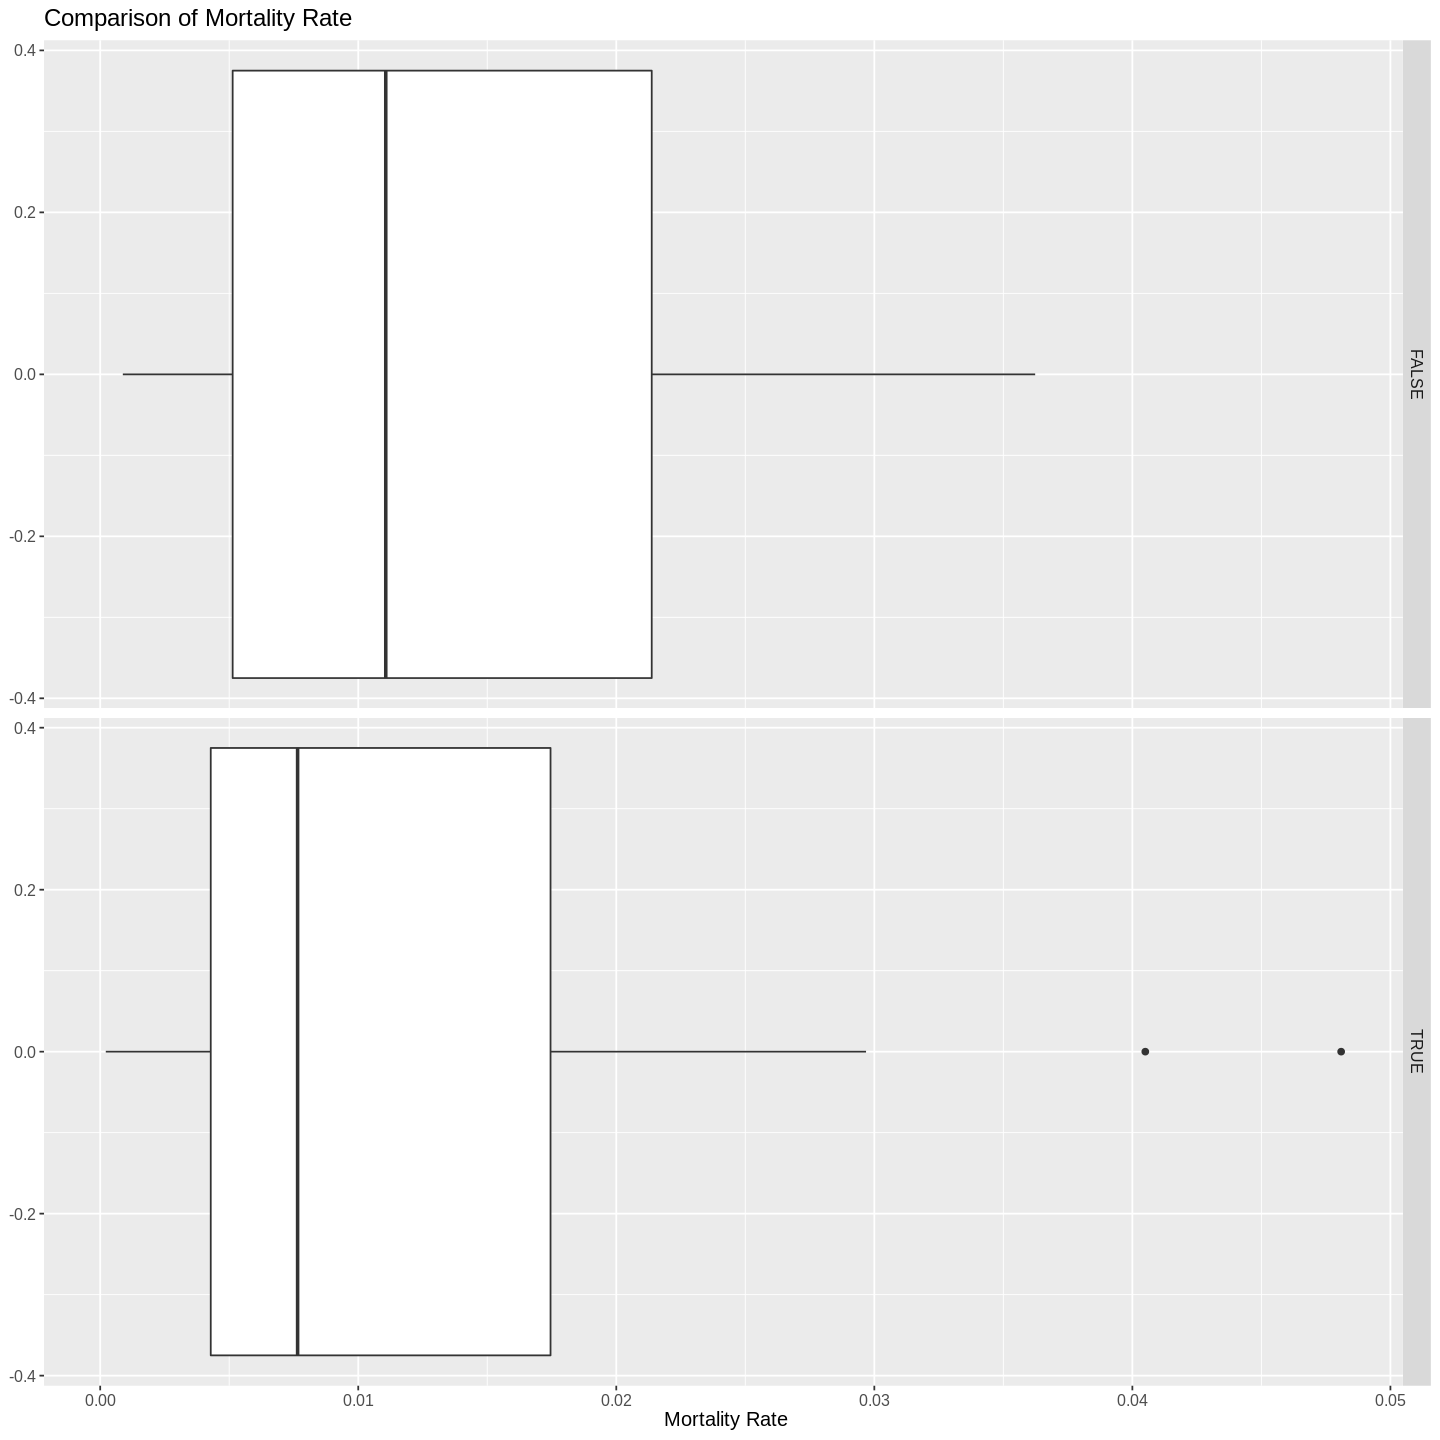

In [7]:
ggplot(data = data_final) +
    geom_boxplot(aes(x = mortality_rate)) +
    facet_grid(vars(is_high_smoking_rate)) +
    labs(x = " Mortality Rate", title = "Comparison of Mortality Rate") + 
    theme(text = element_text(size = 12))

Next, we calculated the mean mortality rate of countries with high smoking rate by using `summary`. The mean was approximately 0.0118.

In [8]:
summary(high_smoking_data)

 mortality_rate     
 Min.   :0.0002169  
 1st Qu.:0.0042844  
 Median :0.0076505  
 Mean   :0.0117543  
 3rd Qu.:0.0174525  
 Max.   :0.0480912  

Likewise, we calculated the mean mortality rate of countries with low smoking rate by using `summary`. The mean was approximately 0.0132.

In [9]:
summary(low_smoking_data)

 mortality_rate     
 Min.   :0.0008769  
 1st Qu.:0.0051335  
 Median :0.0110668  
 Mean   :0.0132401  
 3rd Qu.:0.0213736  
 Max.   :0.0362337  

For the standard error, we used the `infer` package to make a bootstrap distribution of the mean mortality rate. Our standard error was the spread of the bootstrap distribution's histogram. The standard error for mortality rate in high smoking rate countries was 0.0028.

In [10]:
set.seed(2022)
high_smoking_sample <- high_smoking_data %>% rep_sample_n(size = 20, reps = 1, replace = F)
high_smoking_bootstrap <- high_smoking_sample %>% specify(response = mortality_rate) %>%
                          generate(reps = 10000, type = "bootstrap") %>% 
                          calculate(stat = "mean")

high_smoking_se <- high_smoking_bootstrap %>% summarise(se = sd(stat))
high_smoking_data_vis <- high_smoking_bootstrap %>% ggplot(aes(x = stat)) + geom_histogram(, fill = "grey", color = "black") + 
                        labs(x = " Mortality Rate Means", title = "Bootstrap Distribution of Mortality Rate Means (high smoking rate)") + 
                        theme(text = element_text(size = 12))

By the same token, the estimated standard error of mortality rate of low smoking rate countries is 0.0024. And we set the two plots side-by-side.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



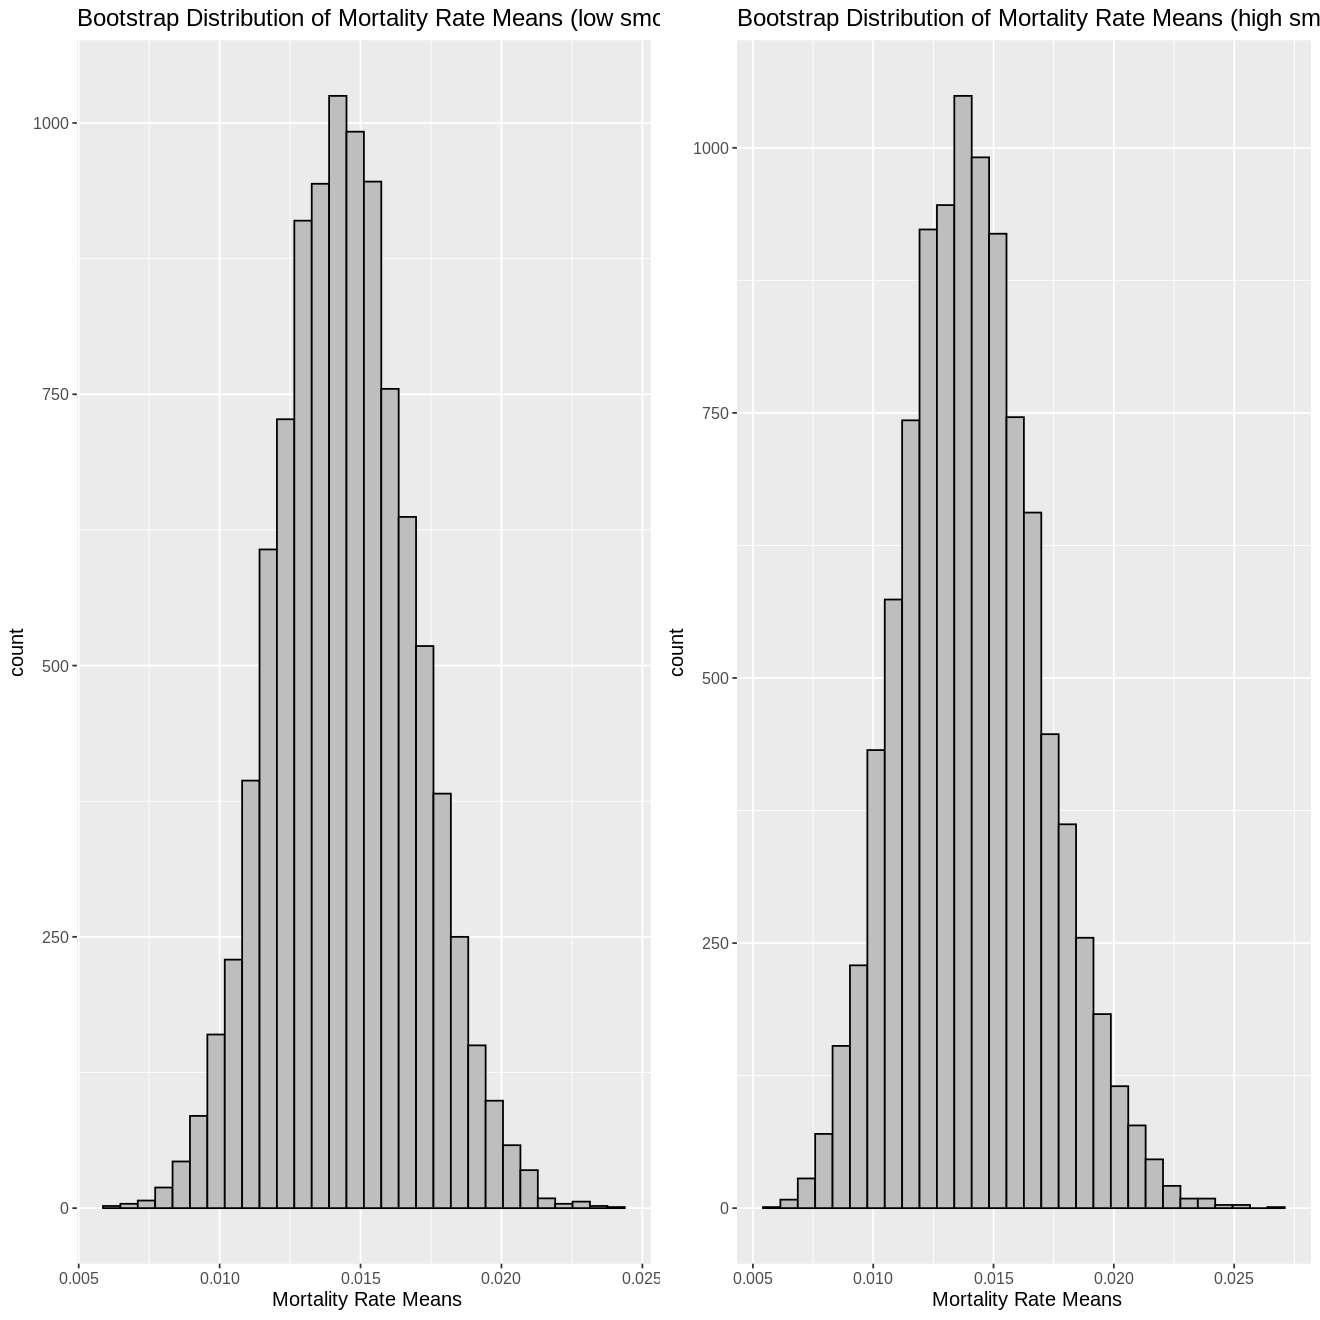

In [14]:
set.seed(2022)
options(repr.plot.width = 11, repr.plot.height = 11)
low_smoking_sample<- low_smoking_data %>% rep_sample_n(size = 20, reps = 1, replace = F)
low_smoking_bootstrap <- low_smoking_sample %>% specify(response = mortality_rate) %>%
                          generate(reps = 10000, type = "bootstrap") %>% 
                          calculate(stat = "mean")
low_smoking_se <- low_smoking_bootstrap %>% summarise(se = sd(stat))

low_smoking_data_vis <- low_smoking_bootstrap %>% ggplot(aes(x = stat)) + geom_histogram(fill = "grey", color = "black") + 
                        labs(x = " Mortality Rate Means", title = "Bootstrap Distribution of Mortality Rate Means (low smoking rate)") + 
                        theme(text = element_text(size = 12))

bootstrap_compare <- grid.arrange(low_smoking_data_vis,high_smoking_data_vis,ncol=2)

Our final result is presented in the data frame below.

In [12]:
result <- data.frame(mean_highsmoking = mean(high_smoking_data$mortality_rate),
                 se_highsmoking = high_smoking_se,
                 mean_lowsmoking = mean(low_smoking_data$mortality_rate),
                 se_lowsmoking = low_smoking_se)
result

mean_highsmoking,se,mean_lowsmoking,se.1
<dbl>,<dbl>,<dbl>,<dbl>
0.01175432,0.002819303,0.01324007,0.00237919


Finally, we performed a 2-sampled t-test at a 5% significance level:

Our null hypothesis was countries with a high smoking rate have the same mortality rate as countries with a low smoking rate. 


$H_0: \bar{X1} = \bar{X2}$

$H_1: \bar{X1} > \bar{X2}$

Here we used a two-sided test to see if the mean mortality rate of countries with high smoking rates was higher than that of low smoking rate countries with the help of the `t.test` function. Our p-value was 0.75, which was significantly higher than 0.05. Therefore, we could not reject the null hypothesis that the mean mortality rate countries with high smoking rate is greater than that of low smoking countries.

In [13]:
test <- tidy(
    t.test(x = high_smoking_data$mortality_rate,
           y = low_smoking_data$mortality_rate,
           alternative = "greater")
    )
test

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-0.00148575,0.01175432,0.01324007,-0.6851582,0.7524316,83.71631,-0.005092491,Inf,Welch Two Sample t-test,greater



## Discussion


As a result of our analysis, we found there are no significant correlation between a country’s COVID-19 death rate, and their smoking rate. These results were inconclusive, which in addition to the already published research provides a solid foundation for further study. Since the results were not in line with what we expected to find - a correlation between smoking rate and COVID-19 death rate - we believe there are other factors in the dataset that directly influence mortality rate such as health care standards (including vaccination rate), overall economic health, education levels, political policy (lockdown frequency and durations). As a result of this study, further research is required with different analysis techniques to attempt to account for the aforementioned factors. Due to the nature of this study – a broad overview of all countries - further study could look deeper into specific countries, regions or cultures and their relationships with smoking compared to their respective COVID-19 death rates. Further research could also focus on specific demographics of the people in each country (e.g., Teenagers, adults), or split countries up based on their GDP, population, etc..

In all, this study does not conclude there is correlation between a country’s smoking rate and its COVID-19 death rate, however, it raises an interesting topic that there are other factors that affect a country’s success during the pandemic to a greater degree.



## References
Alimohamadi, Y., Sepandi, M., Taghdir, M., & Hosamirudsari, H. (2020). Determine the most common clinical symptoms in COVID-19 patients: a systematic review and meta-analysis.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Journal of preventive medicine and hygiene, 61(3), E304–E312. https://doi.org/10.15167/2421-4248/jpmh2020.61.3.1530

Carvalho, T., Krammer, F., & Iwasaki, A. (2021). The first 12 months of COVID-19: A timeline of immunological insights. Nature Reviews Immunology, 21(4), 245–256.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; https://doi.org/10.1038/s41577-021-00522-1 

Desai, A. D., Lavelle, M., Boursiquot, B. C., & Wan, E. Y. (2022). Long-term complications of COVID-19. American Journal of Physiology-Cell Physiology, 322(1), C1–C11. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; doi:10.1152/ajpcell.00375.2021

Edouard Mathieu, Hannah Ritchie, Lucas Rodés-Guirao, Cameron Appel, Charlie Giattino, Joe Hasell, Bobbie Macdonald, Saloni Dattani, Diana Beltekian, Esteban Ortiz-Ospina, & Max 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Roser (2020). Coronavirus Pandemic (COVID-19). Our World in Data.

Gan, H., Hou, X., Zhu, Z., Xue, M., Zhang, T., Huang, Z., Cheng, Z. J., & Sun, B. (2022). Smoking: A leading factor for the death of chronic respiratory diseases derived from Global 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Burden of Disease Study 2019. BMC Pulmonary Medicine, 22(1). https://doi.org/10.1186/s12890-022-01944-w 

Hou, H., Li, Y., Zhang, P., Wu, J., Shi, L., Xu, J., Diao, J., Wang, Y., & Yang, H. (2021). Smoking Is Independently Associated With an Increased Risk for COVID-19 Mortality: A 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Systematic Review and Meta-analysis Based on Adjusted Effect Estimates. Nicotine & tobacco research : 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; official journal of the Society for Research on Nicotine and Tobacco, 23(11), 1947–1951. https://doi.org/10.1093/ntr/ntab112 

Piasecki, T. M., Smith, S. S., Baker, T. B., Slutske, W. S., Adsit, R. T., Bolt, D. M., … Fiore, M. C. (09 2022). Smoking Status, Nicotine Medication, Vaccination, and COVID-19 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Hospital Outcomes: Findings from the COVID EHR Cohort at the University of Wisconsin (CEC-UW) Study. Nicotine & Tobacco Research. doi:10.1093/ntr/ntac201

